In [27]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# Configure matplotlib for better visuals
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
pokemon_df = pd.read_csv('data/pokemon_dataset.csv', index_col=0)
moves_df = pd.read_csv('data/move_dataset.csv', index_col=0) # All Pokemon moves minus banned ones.
learnset_df = pd.read_csv('data/learnset_dataset.csv', index_col=0) # Matrix of whether Pokemon can learn move or not (only Pokemon with >=4 movesets)


In [14]:
weights = np.linspace(0, 1, 11)  # Weights from 0 to 1 in increments of 0.1
f1_values = []
f2_values = []
objective_values = []

for weight in weights:
    filename = f'teams/team_={round(weight, 6)}.csv'
    fvalfilename = f'results/v2team_f_values={round(weight, 6)}.csv'
    try:
        with open(fvalfilename, 'r') as f:
            f1, f2 = f.readline().strip().split(',')
            f1_values.append(float(f1))
            f2_values.append(float(f2))
            objective_values.append(float(f1) + float(f2))
            print(f"Results for weight={weight}: f1={f1}, f2={f2}")
        
        with open(filename, 'r') as f:
            print(f"Team for weight={weight}:")
            for line in f:
                print(line.strip())
    except FileNotFoundError:
        print(f"Results file for weight={round(weight, 6)} not found.")
        f1_values.append(None)
        f2_values.append(None)
        objective_values.append(None)


Results for weight=0.0: f1=2262.1, f2=8808.118812
Team for weight=0.0:
53,106,249,738,741
164,184,237,712,713
313,106,249,352,712
400,106,131,249,352
520,106,352,663,738
719,518,712,713,774
Results for weight=0.1: f1=2460.5, f2=8808.118812
Team for weight=0.1:
53,106,249,738,741
164,184,237,712,713
313,106,249,352,712
400,106,131,249,352
520,106,352,663,738
719,518,712,713,774
Results for weight=0.2: f1=2460.5, f2=8808.118812
Team for weight=0.2:
53,106,249,738,741
164,184,237,712,713
313,106,249,352,712
400,106,131,249,352
520,106,352,663,738
719,518,712,713,774
Results for weight=0.30000000000000004: f1=2460.5, f2=8808.118812
Team for weight=0.30000000000000004:
53,106,249,738,741
164,184,237,712,713
313,106,249,352,712
400,106,131,249,352
520,106,352,663,738
719,518,712,713,774
Results for weight=0.4: f1=2460.5, f2=8808.118812
Team for weight=0.4:
53,106,249,738,741
164,184,237,712,713
313,106,249,352,712
400,106,131,249,352
520,106,352,663,738
719,518,712,713,774
Results for weight

11
11
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


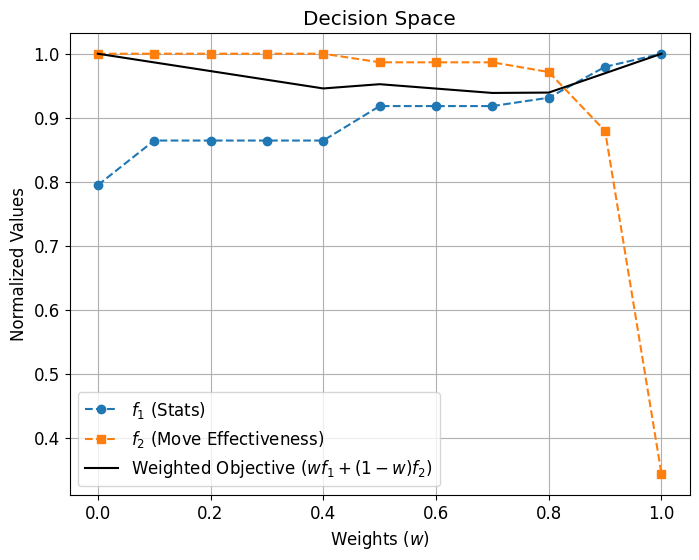

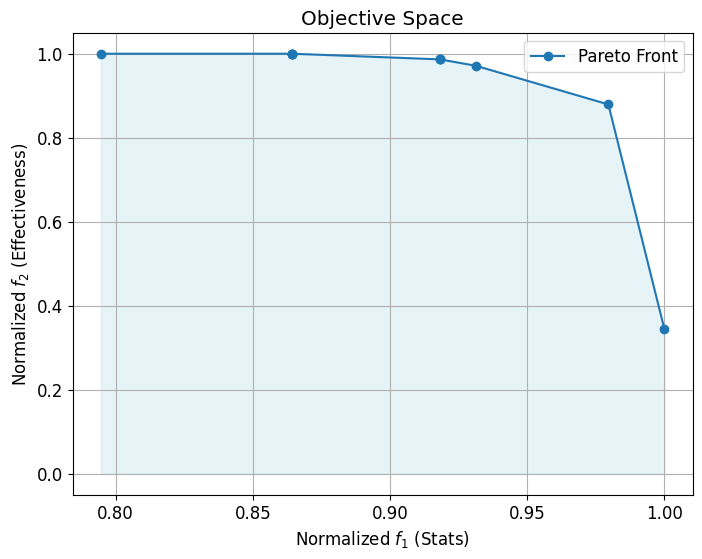

[0.7946394070327045, 0.8643341412864018, 0.8643341412864018, 0.8643341412864018, 0.8643341412864018, 0.9181859697193242, 0.9181859697193242, 0.9181859697193242, 0.9312537323918925, 0.9795552745284014, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9865672983612791, 0.9865672983612791, 0.9865672983612791, 0.9713922798524575, 0.8792838515584728, 0.34368044784725593]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [ ]:

max_f1 = max(f1_values)
max_f2 = max(f2_values)

normalized_f1 = [x / max_f1 for x in f1_values]
normalized_f2 = [x / max_f2 for x in f2_values]
plt.figure()
plt.plot(weights, normalized_f1, 'o--', label='$f_1$ (Stats)')
plt.plot(weights, normalized_f2, 's--', label='$f_2$ (Move Effectiveness)')

# Weighted objective function
weighted_objective = [
    w * f1 + (1 - w) * f2 
    for w, f1, f2 in zip(weights, normalized_f1, normalized_f2)
    if f1 is not None and f2 is not None
]

print(len(weighted_objective))
print(len(weights))
print(weights)
plt.plot(weights, weighted_objective, 'k-', label='Weighted Objective ($w f_1 + (1 - w) f_2$)')

# Add labels and legend
plt.title('Decision Space')
plt.xlabel('Weights ($w$)')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.show()

# Filter out None values for plotting

# Plot the Pareto front (Objective Space)
plt.figure()
plt.plot(normalized_f1, normalized_f2, 'o-', label='Pareto Front')

# Fill the area under the Pareto front
plt.fill_between(
    normalized_f1,  # x-coordinates
    normalized_f2,  # y-coordinates
    color='lightblue',  # Fill color
    alpha=0.3,  # Transparency
    # label='Shaded Area Under Pareto Front'  # Legend label
)

# Add labels and legend
plt.title('Objective Space')
plt.xlabel('Normalized $f_1$ (Stats)')
plt.ylabel('Normalized $f_2$ (Effectiveness)')
plt.legend()
plt.grid(True)
plt.show()

print(normalized_f1)
print(normalized_f2)
print(weights)


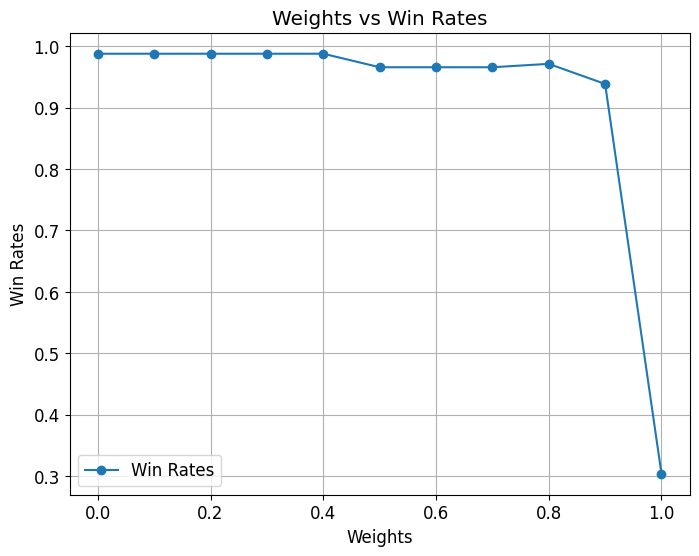

In [38]:
win_rates = []
for weight in weights:
    filename = f'results/v2team_={round(weight, 6)}.csv'
    with open(filename, 'r') as file:
        win_rates.extend([float(line.strip()) for line in file])

# Ensure the length of win_rates matches the length of weights
if len(win_rates) != len(weights):
    raise ValueError("The length of win_rates does not match the length of weights")

# Plot weights vs win rates
plt.figure()
plt.plot(weights, win_rates, 'o-', label='Win Rates')
plt.title('Weights vs Win Rates')
plt.xlabel('Weights')
plt.ylabel('Win Rates')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
random_scores = []
for i in range(125):
    with open(f'results/random_team_{i}.csv', 'r') as f:
        s = float(f.read())
        random_scores.append(s)

Text(0.5, 0, 'Random Teams')

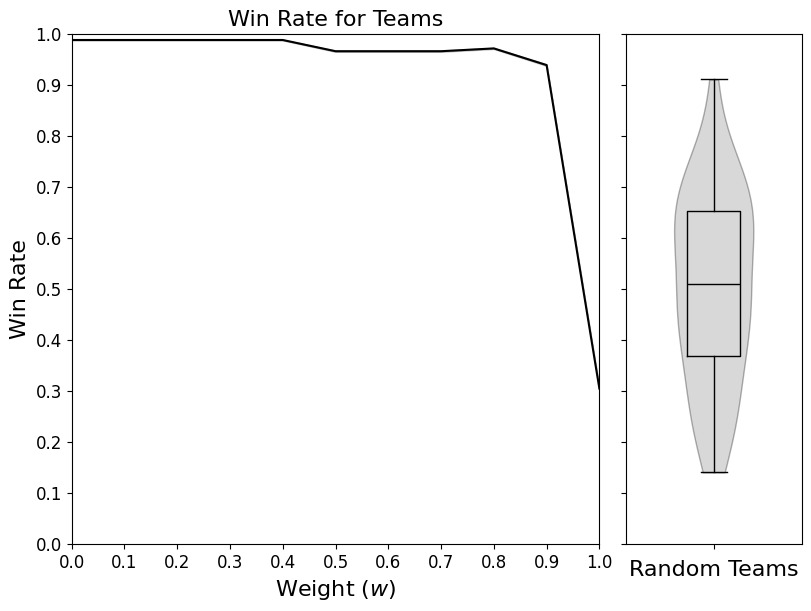

In [ ]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AAAB
    """
)

# # Plot the decision space
# upper = [p + (scipy.stats.norm(loc=0, scale=1).ppf(0.9)/2) * ((p*(1-p))/10000)**0.5 for p in win_rates]
# lower = [p - (scipy.stats.norm(loc=0, scale=1).ppf(0.9)/2) * ((p*(1-p))/10000)**0.5 for p in win_rates]

# # Fill between lower and upper bounds (commented out)
# axd['A'].fill_between(weights, lower, upper, color='gray', alpha=0.5)
axd['A'].set_title('Win Rate for Teams', fontsize=16)

# Line plot for scores
axd['A'].plot(weights, win_rates, c='black')
axd['A'].set_xlabel(r'Weight ($w$)', fontsize=16)  # X-axis label: "Weight (w)"
axd['A'].set_ylabel('Win Rate', fontsize=16)       # Y-axis label: "Win Rate"
axd['A'].set_xlim(0, 1)                            # X-axis limits
axd['A'].set_ylim(0, 1)                            # Y-axis limits
axd['A'].set_xticks([round(i * 0.1, 2) for i in range(11)])  # X-axis ticks (0 to 1 in steps of 0.1)
axd['A'].set_yticks([round(i * 0.1, 2) for i in range(11)])  # Y-axis ticks (0 to 1 in steps of 0.1)

# Violin plot for random team scores
viols = axd['B'].violinplot(random_scores, showextrema=False, widths=0.45)
for pc in viols['bodies']:
    pc.set_facecolor('grey')      # Set fill color to grey
    pc.set_edgecolor('black')     # Set edge color to black
    pc.set_alpha(0.3)             # Set transparency to 0.3

# Box plot for random team scores
boxes = axd['B'].boxplot(random_scores, medianprops=dict(color="black"), widths=0.3)
axd['B'].set_ylim(0, 1)          # Y-axis limits
axd['B'].set_yticks([round(i * 0.1, 2) for i in range(11)])  # Y-axis ticks (0 to 1 in steps of 0.1)
axd['B'].set_yticklabels([])     # Remove Y-axis tick labels
axd['B'].set_xticklabels([])     # Remove X-axis tick labels
axd['B'].set_xlabel('Random Teams', fontsize=16)  # X-axis label: "Random Teams"

In [49]:
# selected_pokemon = [p for p in pokemon_df.index if X[p].varValue == 1]
# selected_pokemon_roles = {pokemon_df.loc[p, "Name"]: [r for r in roles if R[(p, r)].varValue == 1] for p in selected_pokemon}
# selected_pokemon_roles_df = pd.DataFrame(list(selected_pokemon_roles.items()), columns=["Pokemon", "Assigned_Roles"])

# selected_moves = [(pokemon_df.loc[p, "Name"], a) for p in pokemon_df.index for a in pokemon_moves[p] if Y[(p, a)].varValue == 1]
# selected_moves_df = pd.DataFrame(selected_moves, columns=["Pokemon", "Move"])
# selected_moves_details_df = moves_df.loc[moves_df.index.isin(selected_moves_df["Move"]), ["Name"]]
# selected_moves_details_df = selected_moves_details_df.rename(columns={"Name": "Move_Name"})
# selected_moves_df = selected_moves_df.merge(selected_moves_details_df, left_on="Move", right_index=True)

# slack_values = []
# for _, row in selected_moves_df.iterrows():
#     pokemon_name = row["Pokemon"]
#     move_name = row["Move"]
#     for role in selected_pokemon_roles[pokemon_name]:
#         slack_value = slack_vars[(pokemon_df[pokemon_df['Name'] == pokemon_name].index[0], move_name, role)].varValue
#         slack_values.append((pokemon_name, move_name, role, slack_value))

# slack_df = pd.DataFrame(slack_values, columns=["Pokemon", "Move", "Role", "Slack_Value"])
# selected_moves_with_slack_df = selected_moves_df.merge(slack_df, on=["Pokemon", "Move"])


# selected_pokemon_roles_df


# selected_moves_with_slack_df

filename = 'teams/v2team_=0.8.csv'
# csv format:
# 53,106,249,738,741,Hybrid
# 164,184,237,712,713,Physical Sweeper
# 313,106,249,352,712,Mixed Sweeper
# 400,106,131,249,352,Drainer
# 520,106,352,663,738,Special Sweeper
# 719,518,712,713,774,Tank
selected_pokemon_moves = []

with open(filename, 'r') as file:
    for line in file:
        parts = line.strip().split(',')
        pokemon_id = int(parts[0])
        move_ids = list(map(int, parts[1:5]))
        role = parts[5]
        pokemon_name = pokemon_df.loc[pokemon_id, 'Name']
        move_names = moves_df.loc[move_ids, 'Name'].tolist()
        selected_pokemon_moves.append((pokemon_name, move_names, role))

selected_pokemon_moves_df = pd.DataFrame(selected_pokemon_moves, columns=['Pokemon', 'Moves', 'Role'])
pd.set_option('display.max_colwidth', None)

print(selected_pokemon_moves_df)



     Pokemon                                                    Moves  \
0    Steelix           [Crunch, Earthquake, Steel Beam, Steel Roller]   
1  Heracross       [Brick Break, Close Combat, Focus Punch, Megahorn]   
2    Blissey      [Double-Edge, Giga Impact, Hyper Beam, Thunderbolt]   
3   Blaziken      [Blast Burn, Close Combat, Focus Punch, Superpower]   
4    Lucario  [Close Combat, Focus Punch, High Jump Kick, Steel Beam]   
5  Primarina              [Hydro Cannon, Moonblast, Play Rough, Surf]   

               Role  
0           Drainer  
1  Physical Sweeper  
2              Tank  
3            Hybrid  
4     Mixed Sweeper  
5   Special Sweeper  
